# Biometrical photo

In [1]:

import cv2
import os
import numpy as np
from deeplab import *
from PIL import Image

import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import base64



In [2]:
CHECK_DIM = 0
DEBUG = 1
if CHECK_DIM:
    for root,dirs,files in os.walk("./Data/"):
        for file in files:
            if file.endswith("jpg"):
                img = cv2.imread(os.path.join(root, file))
                if img.shape[:2]!=(3072, 4608):
                    print(img.shape[:2])

## Initial Image, after the validation algorithm 

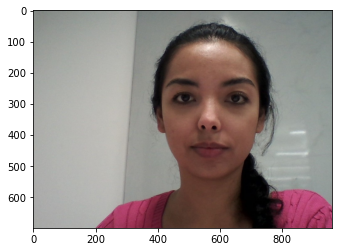

In [55]:

img = cv2.imread("./in_pic.jpg")

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()



<function matplotlib.pyplot.show(close=None, block=None)>

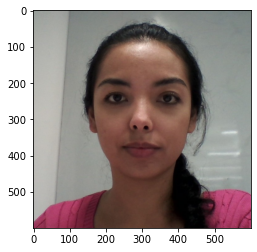

In [56]:
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

(h, w) = img.shape[:2]
if w>=h:
    height = 600
    ratio = height / h
    dim = (int(w*ratio), height)
else:
    width = 600
    ratio = width / w
    dim = (width, int(h*ratio))

img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.3, 4)

# assert len(faces)==1

for (x_f, y_f, w_f, h_f) in [faces[0]]:
    img=img
    #if DEBUG:
        #cv2.rectangle(img, (x_f, y_f), (x_f+w_f, y_f+h_f), (255, 0, 0), 2)

#plt.figure()
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#plt.show
#crop to 600x600
if w>=h:
    width_crop = (height-(w_f))/2
    if width_crop.is_integer():
        img = img[:, x_f-int(width_crop):x_f+w_f+int(width_crop)]
    else:
        img = img[:, x_f-int(np.floor(width_crop)):x_f+w_f+int(np.ceil(width_crop))]
else:
    height_crop = (width-(h_f))/2
    if height_crop.is_integer():
        img = img[y_f-int(height_crop):y_f+h_f+int(height_crop), :]
    else:
        img = img[y_f-int(np.floor(height_crop)):y_f+h_f+int(np.ceil(height_crop)), :]    

assert img.shape==(600,600, 3), "wrong shape:"+str(img.shape)

#plt.figure()
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#plt.show

In [ ]:
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

In [13]:
MODEL_NAME = 'xception_coco_voctrainval'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']
MODEL_DIR = "./Models"
""""_TARBALL_NAME = MODEL_NAME+'.tar.gz' """ 

MODEL_NAME = 'xception_coco_voctrainval'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(MODEL_DIR, _TARBALL_NAME)
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                               download_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pil_im = Image.fromarray(img)
MODEL = DeepLabModel(download_path)

resized_im, seg_map = MODEL.run(pil_im)

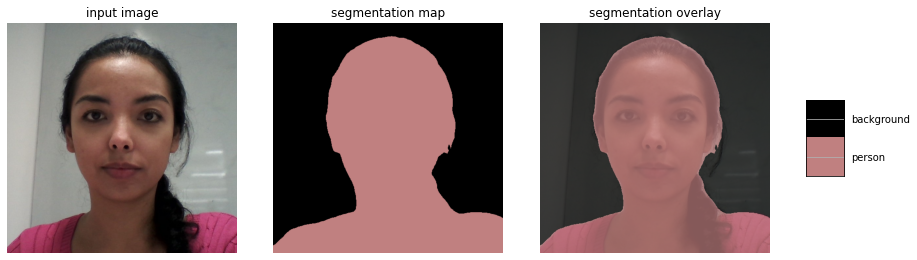

In [14]:
vis_segmentation(resized_im, seg_map)

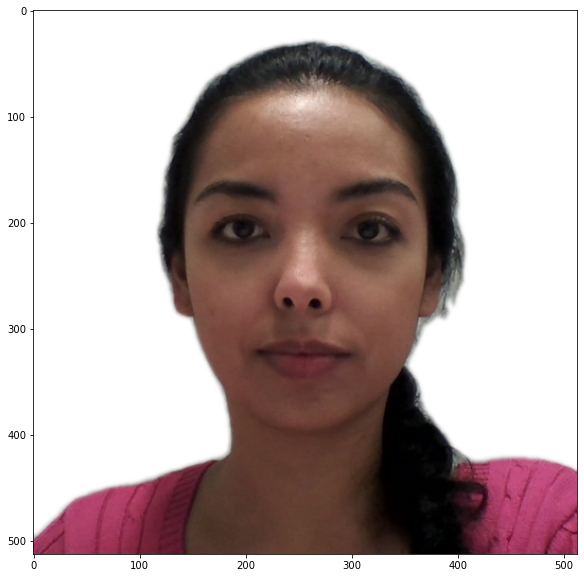

In [10]:
mask = Image.fromarray(create_pascal_label_colormap()[seg_map].astype(np.uint8))

background = 255 * np.ones_like(mask).astype(np.uint8)

foreground = np.array(resized_im.getdata()).reshape(resized_im.size[0], resized_im.size[1], 3).astype(float)
background = background.astype(float)

th, alpha = cv2.threshold(np.array(mask),0,255, cv2.THRESH_BINARY)
alpha = cv2.GaussianBlur(alpha, (9,9),0)
alpha = alpha.astype(float)/255


foreground = cv2.multiply(alpha, foreground)
background = cv2.multiply(1.0 - alpha, background)
outImage = cv2.add(foreground, background)


plt.figure(figsize=(10,10))
plt.imshow(outImage/255)
plt.show()

In [11]:
pil_im = Image.fromarray((outImage).astype(np.uint8))
pil_im.save('seg_imfinal.jpg')